Imports and Torch version

In [43]:
# IMPORTS
import torch
import torchvision
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as tfs
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import pandas as pd

print(torch.__version__)

2.1.0+cu118


Downloading MNIST Dataset

In [44]:
train_set = datasets.MNIST(
    root='./',
    train=True,
    download=True,
    transform=tfs.Compose([tfs.ToTensor()])
)

test_set = datasets.MNIST(
    root='./',
    train=False,
    download=True,
    transform=tfs.Compose([tfs.ToTensor()])
)

Data Loaders and Training/Validation split

In [45]:
num_workers = 0
batch_size = 128
valid_size = 0.2

num_train = len(train_set)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_index , valid_index = indices[split:],indices[:split]

train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         num_workers=num_workers)

Exercise 1

In [46]:
# Gets the number of true positives by comparing the predictions and labels
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()


MLP Model

In [47]:
class MLP(nn.Module):
    # Inilize variables
    def __init__(self):
        super(MLP, self).__init__()
        self.Input = nn.Linear(in_features=784,out_features=512)
        self.Dropout1 = nn.Dropout(0.2)
        self.Hidden = nn.Linear(in_features=512,out_features=512)
        self.Dropout2 = nn.Dropout(0.2)
        self.Predictions = nn.Linear(in_features=512,out_features=10)
    # forward is used to describe the behavior of the model during a feed forward pass
    def forward(self, input_tensor):
        #Flatten the w and h of the image (2D --> 1D)
        x = torch.flatten(input_tensor,start_dim=1)
        x = self.Input(x)
        #Apply non linear activation function relu
        x = F.relu(x)
        x = self.Dropout1(x)
        x = self.Hidden(x)
        x = F.relu(x)
        x = self.Dropout2(x)
        x = self.Predictions(x)
        #Apply Softmax to the output of the model then return the result
        x = F.log_softmax(x, dim=1)
        return x
    # __repr__ returns the models architecture when called
    def __repr__(self):
        return super().__repr__()

Training the MLP model

In [53]:
model = MLP()
print(model.parameters())
optimizer = optim.RMSprop(model.parameters(),lr=0.001)
writer = SummaryWriter(log_dir='/mnt/d/VSCode/TD_Systèmes_Intelligents_Avancés/Results/MLP/') #Initializing Tensorboard to store logs in the specified directory
n_epochs = 20 # number of epochs to train the model
for epoch in range(n_epochs):
    train_loss = 0
    val_loss = 0
    train_correct = 0
    val_correct = 0
    #Changing model state to train 
    model.train()
    for batch in train_loader: 
        images, labels = batch
        #Sets the gradients of all optimized torch.Tensors to zero.
        optimizer.zero_grad()
        preds = model(images) # Pass or forward batch
        loss = F.cross_entropy(preds, labels) # Calculate loss using cross entropy multiclass
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights
        #Add batch loss value to train loss (We want the mean)
        train_loss += loss.item() * images.size(0)
        #Add batch TP (True Positive) value to train correct (We want the mean Accuracy)
        train_correct += get_num_correct(preds, labels) 
    model.eval()
    for batch in valid_loader:
        images, labels = batch
        preds = model(images)
        loss = F.cross_entropy(preds, labels)
        val_loss += loss.item() * images.size(0)
        val_correct += get_num_correct(preds, labels) 
    #Calculating the epochs values for loss acc val_loss and val_accuracy
    train_loss = train_loss / len(train_loader.sampler)
    val_loss = val_loss / len(valid_loader.sampler)
    accuracy = train_correct / len(train_loader.sampler)
    val_accuracy = val_correct / len(valid_loader.sampler)
    #Adding these scalars to tensorboard usinf add_scalar function
    writer.add_scalar('Loss/loss', train_loss, epoch+1)
    writer.add_scalar('Loss/val_loss', val_loss, epoch+1)
    writer.add_scalar('Accuracy/acc', accuracy, epoch+1)
    writer.add_scalar('Accuracy/val_acc', val_accuracy, epoch+1)
    #Shawing the epochs scalar values
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tAccuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch+1, 
        train_loss,
        val_loss,
        accuracy,
        val_accuracy
        ))
writer.close()

<generator object Module.parameters at 0x7f5a84a62a40>
Epoch: 1 	Training Loss: 1.585665 	Validation Loss: 1.521023 	Accuracy: 0.879854 	Validation Accuracy: 0.942083
Epoch: 2 	Training Loss: 1.510058 	Validation Loss: 1.504779 	Accuracy: 0.953063 	Validation Accuracy: 0.958333


KeyboardInterrupt: 

Matrice de Confusion:

In [49]:
# IMPORTS
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

Evaluating the resulting model the nconstructing the Confusion Matrix

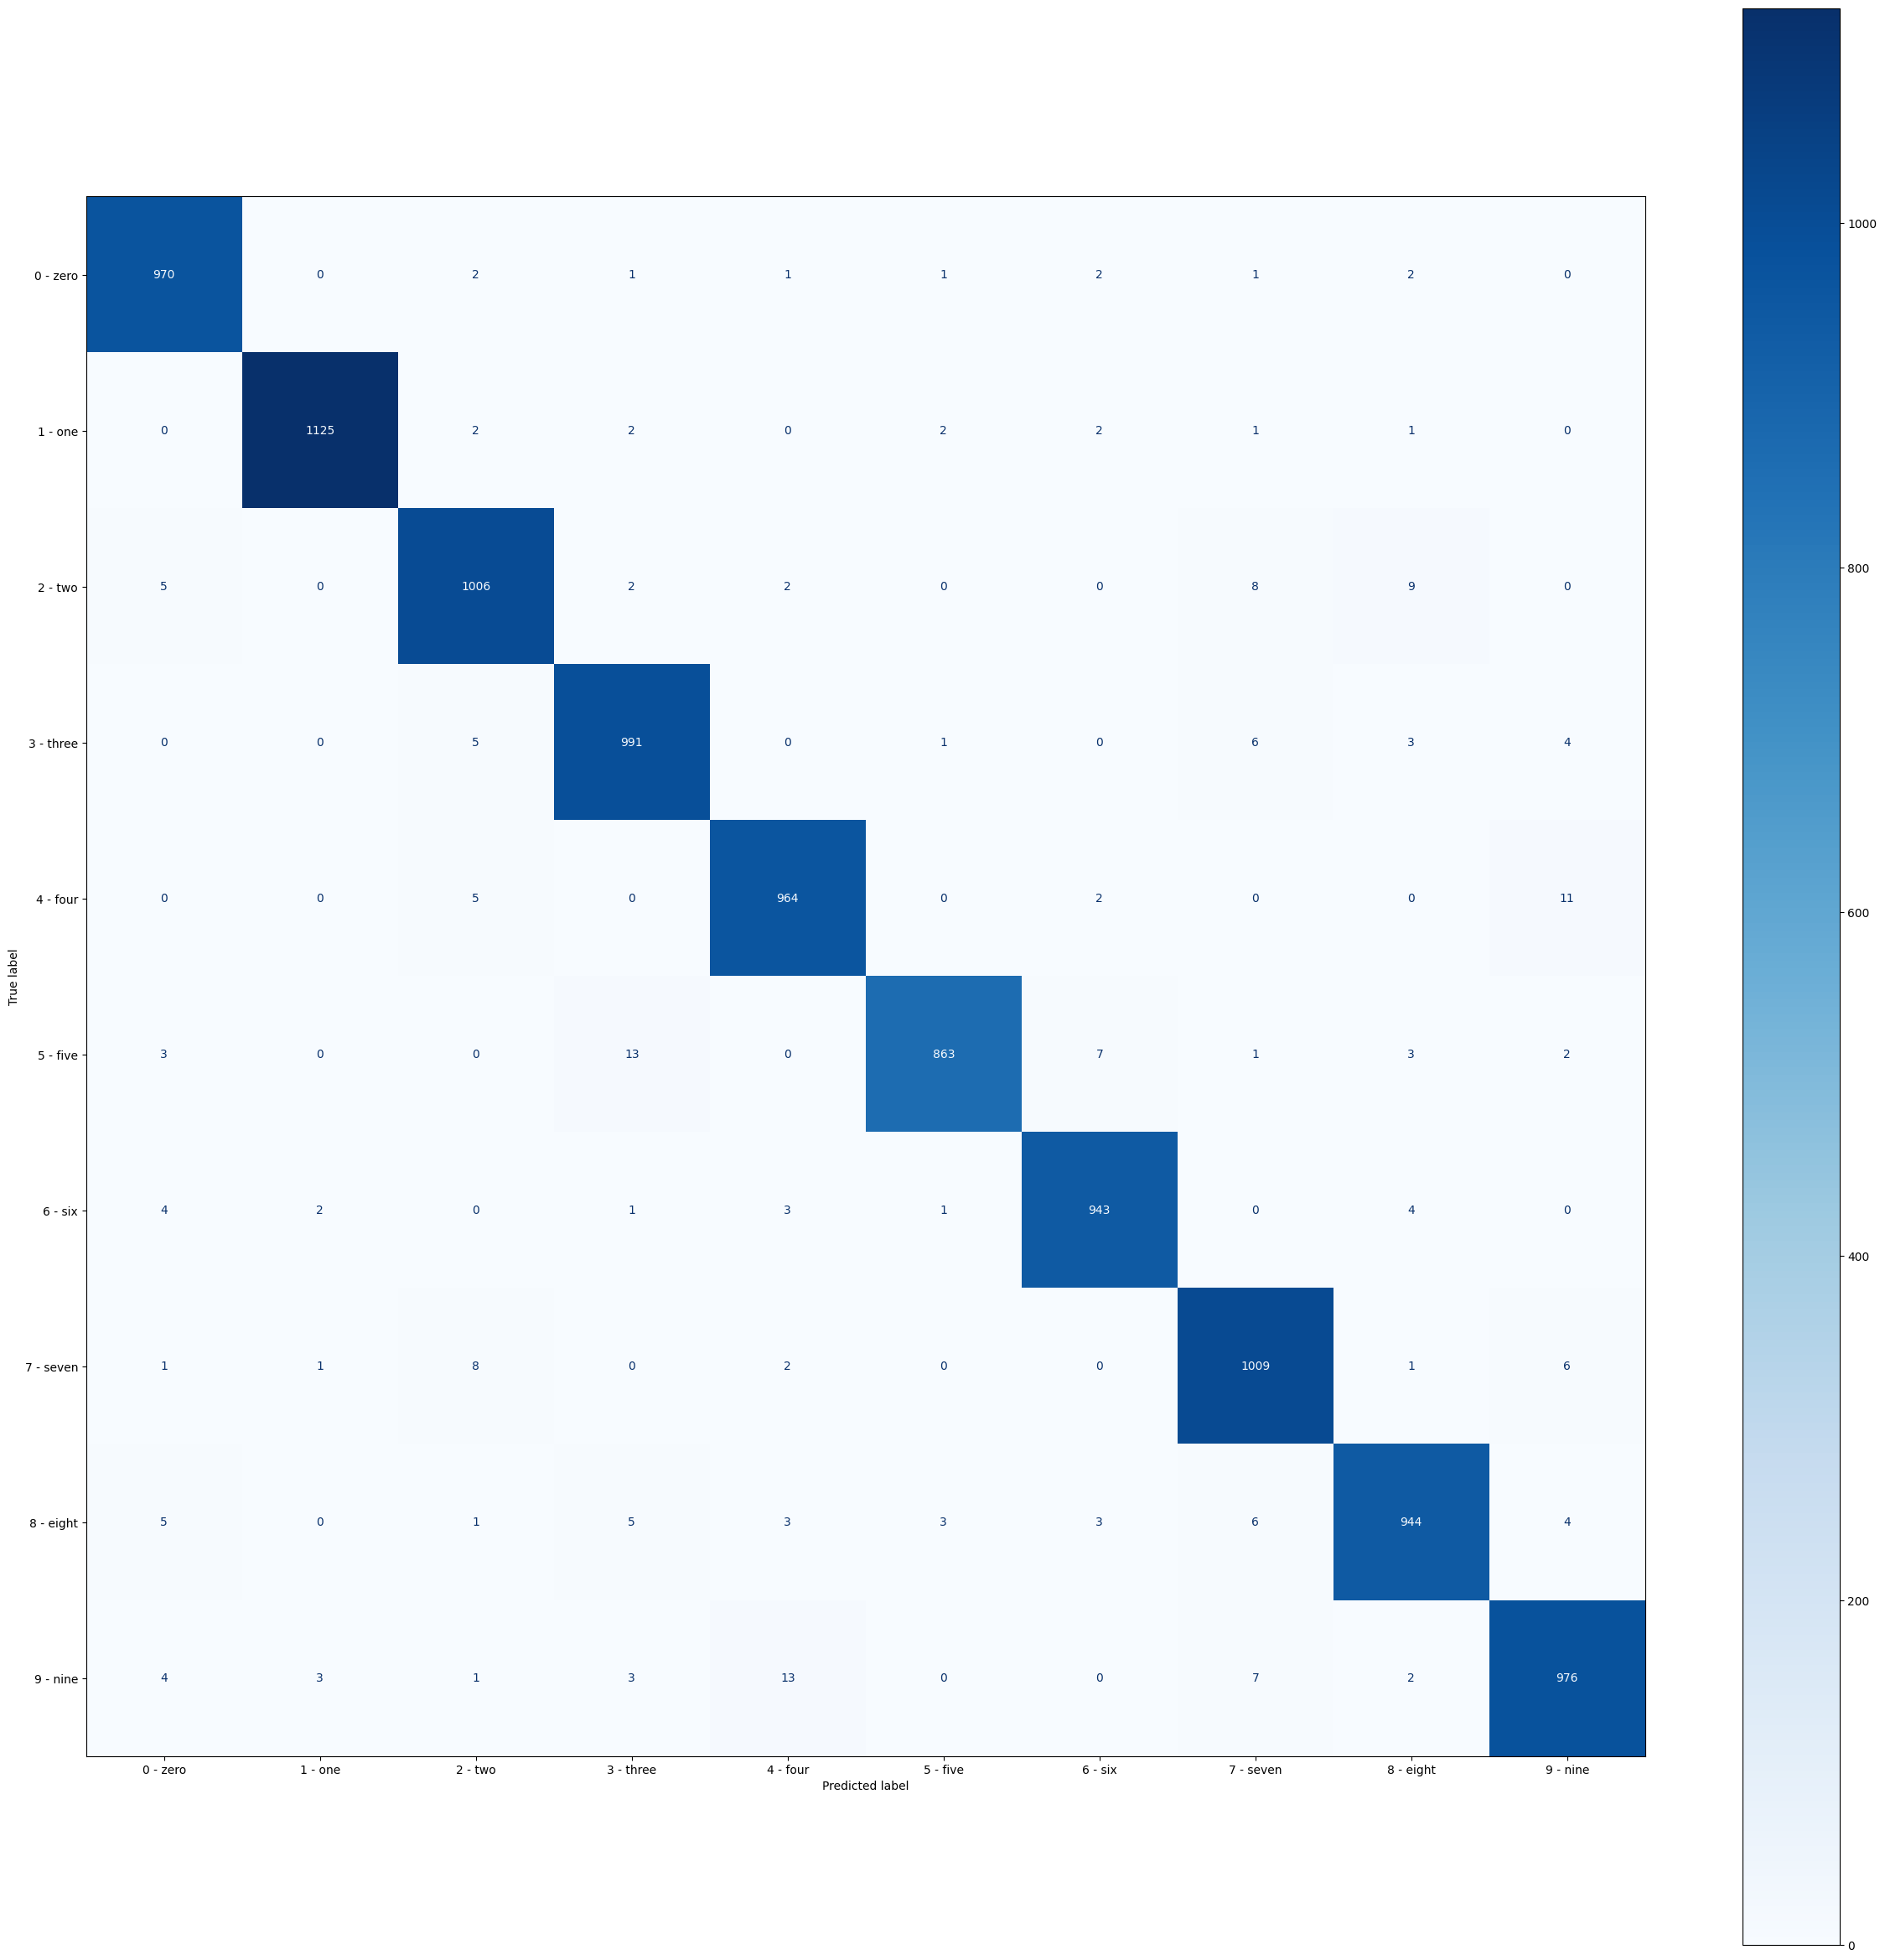

Test Loss: 1.482081

Test Accuracy of     0: 98% (970/980)
Test Accuracy of     1: 99% (1125/1135)
Test Accuracy of     2: 97% (1006/1032)
Test Accuracy of     3: 98% (991/1010)
Test Accuracy of     4: 98% (964/982)
Test Accuracy of     5: 96% (863/892)
Test Accuracy of     6: 98% (943/958)
Test Accuracy of     7: 98% (1009/1028)
Test Accuracy of     8: 96% (944/974)
Test Accuracy of     9: 96% (976/1009)


In [50]:
# Initialize lists to monitor test loss and accuracy
y_pred = []
y_tr = []
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval() # This prepares the model for evaluation
for batch in test_loader:
    images, labels = batch
    preds = model(images)
    y_pred.extend(np.argmax(preds.detach().numpy(), axis=1))
    y_tr.extend(labels.detach().numpy().tolist())
    loss = F.cross_entropy(preds,labels) # Calculate loss
    test_loss += loss.item() * images.size(0) # update test loss
    _, pred = torch.max(preds, 1) # Convert output probabilities to predicted class
    correct = np.squeeze(pred.eq(labels.data.view_as(pred))) # Compare predictions to true label
    for i in range(len(labels)):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

cm = confusion_matrix(y_true=y_tr, y_pred=y_pred)
lbls = test_set.classes
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lbls)
fig,ax = plt.subplots(figsize=(30,30))
cmp.plot(cmap=plt.cm.Blues,ax=ax)
plt.show()
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
        

CNN

In [52]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,kernel_size=3)
        self.conv2 = nn.Conv2d(32,64,kernel_size=3)
        self.dropout1 = nn.Dropout2d(0.5)
        self.maxpool1 = nn.MaxPool2d(2)
        
        